# Time Series Classification Pipeline
Questo notebook raccoglie l'intero flusso di lavoro per il challenge *pirate-pain*: dalla comprensione dei dati grezzi fino alla consegna della submission finale. Le sezioni sono pensate per accompagnare chi legge passo dopo passo, evidenziando le decisioni prese e gli strumenti utilizzati.

## Sezione 1 · Ambiente e librerie
Configuriamo le dipendenze principali, fissiamo i semi per la riproducibilità e impostiamo lo stile dei grafici che verranno visualizzati nei passaggi successivi.

In [99]:
## 1. Setup: librerie e stili
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Preprocessing e metriche
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.utils import resample

# Riproducibilità
np.random.seed(42)
tf.random.set_seed(42)

# Aspetto grafici
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("Impostazione completata.")

TensorFlow version: 2.20.0
GPU Available: []
Impostazione completata.


## Sezione 2 · Esplorazione iniziale
Carichiamo i file messi a disposizione dalla competition e produciamo qualche statistica di base per capire la struttura del problema (numero di campioni, lunghezza delle sequenze e ampiezza del vettore di feature).

In [100]:
## 2. Dataset: caricamento e overview
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

print("Training Data Overview")
print("=" * 50)
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Unique samples: {X_train['sample_index'].nunique()}")
time_counts = X_train.groupby('sample_index').size()
print(f"Time steps per sample (min-max): {time_counts.min()} - {time_counts.max()}")
print(f"Feature columns: {X_train.shape[1]}")

Training Data Overview
Training features shape: (105760, 40)
Training labels shape: (661, 2)
Unique samples: 661
Time steps per sample (min-max): 160 - 160
Feature columns: 40


### 2.1 Prime ispezioni visive
Osserviamo alcune righe di feature e label e visualizziamo distribuzioni chiave per capire squilibri di classe e profondità temporale delle serie.

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain


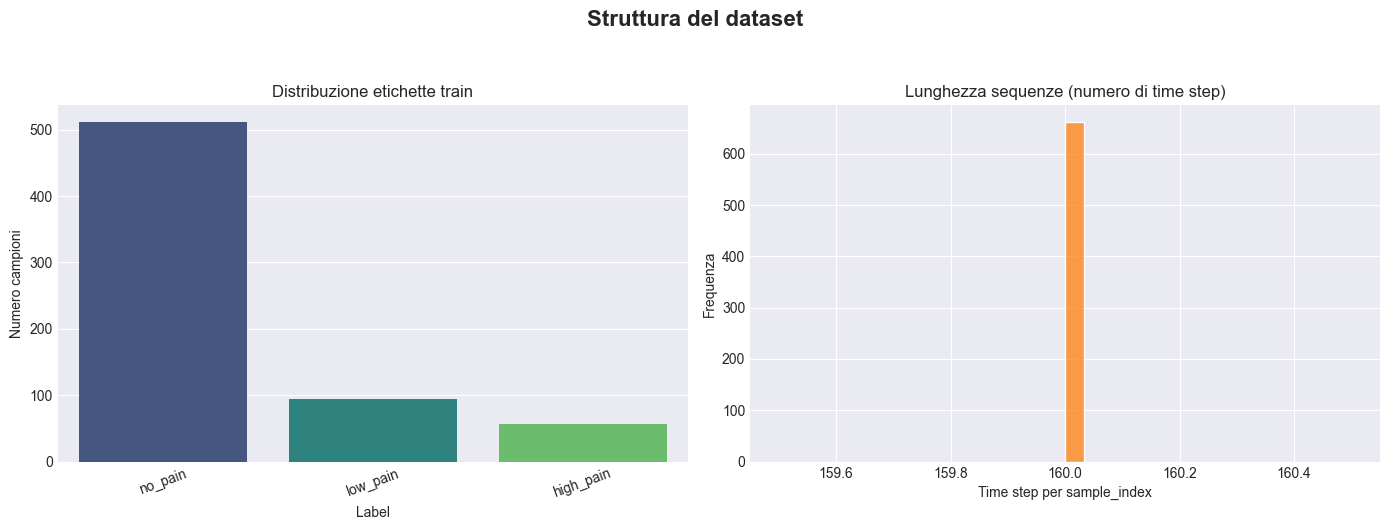

In [101]:
## 3. Snapshot dei dati
display(X_train.head(3))
display(y_train.head(3))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x=y_train['label'], order=y_train['label'].value_counts().index, ax=axes[0], palette="viridis")
axes[0].set_title('Distribuzione etichette train')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Numero campioni')
axes[0].tick_params(axis='x', rotation=20)

sns.histplot(time_counts, bins=30, ax=axes[1], color="#FF7F0E", edgecolor='white')
axes[1].set_title('Lunghezza sequenze (numero di time step)')
axes[1].set_xlabel('Time step per sample_index')
axes[1].set_ylabel('Frequenza')

plt.suptitle('Struttura del dataset', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

## Sezione 3 · Preparazione feature
Rimuoviamo colonne ridondanti e predisponiamo il dataset per la conversione in tensor. In questa fase eliminiamo feature costanti o troppo collinearie per mitigare il rumore.

### 3.1 Pulizia e riduzione
Applichiamo regole semplici ma efficaci: eliminiamo colonne costanti e quelle con correlazione superiore a 0.99 per ridurre la ridondanza e contenere il rischio di overfitting.

## Sezione 4 · Dati in formato sequenza
A partire dalle osservazioni long-form raggruppiamo gli eventi per `series_id`, ordiniamo temporalmente e costruiamo tensori sequenziali con le feature pulite.

In [102]:
## 4. Feature cleaning
id_columns = ['sample_index', 'time']
feature_columns = [col for col in X_train.columns if col not in id_columns]

removed_constant_cols = [col for col in feature_columns if X_train[col].nunique(dropna=False) <= 1]
if removed_constant_cols:
    X_train = X_train.drop(columns=removed_constant_cols)
    feature_columns = [col for col in feature_columns if col not in removed_constant_cols]

numeric_cols = X_train[feature_columns].select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    corr_matrix = X_train[numeric_cols].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    removed_corr_cols = sorted({col for col in upper_tri.columns if any(upper_tri[col] > 0.99)})
else:
    removed_corr_cols = []

if removed_corr_cols:
    X_train = X_train.drop(columns=removed_corr_cols)

remaining_features = [col for col in X_train.columns if col not in id_columns]
print(f"Remaining feature columns: {len(remaining_features)}")

Remaining feature columns: 37


### 3.2 Preprocessing personalizzato
Gestiamo le feature categoriche (numero arti/occhi) mappandole in valori interi e riempiamo eventuali *NaN* con fallback ragionati. Questa funzione verrà riutilizzata sia per train che per test.

## Sezione 5 · Normalizzazione e maschere
Standardizziamo solo le feature cinematiche usando statistiche calcolate sui frame validi (`mask=1`). Manteniamo traccia delle maschere per evitare leakage e preservare i valori statici.

#### Funzione `preprocess_features`
Questa funzione normalizza le colonne non temporali: converte le feature testuali (arti/occhi) in numeri, gestisce i `NaN` e restituisce un array pronto per la creazione delle sequenze.

In [103]:
## 5. Feature preprocessing helpers
def preprocess_features(df):
    """Convert features to numeric form and fill missing values."""
    exclude_cols = ['sample_index', 'time']
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    categorical_cols = [col for col in ['n_legs', 'n_hands', 'n_eyes'] if col in df.columns]

    df_processed = df[feature_cols].copy()

    mapping = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}
    for col in categorical_cols:
        mapped = df_processed[col].map(mapping)
        if mapped.isna().all():
            fill_value = 0
        else:
            mode_series = mapped.mode(dropna=True)
            fill_value = mode_series.iloc[0] if not mode_series.empty else 0
        df_processed[col] = mapped.fillna(fill_value)

    df_processed = df_processed.fillna(0)
    return df_processed.values

print("Preprocessing helper ready.")

Preprocessing helper ready.


### 5.1 Calcolo delle statistiche
Applichiamo le funzioni helper per calcolare media e deviazione standard per ogni giunto sui frame osservati, così da riutilizzare gli stessi parametri su train/val/test.

In [104]:
## 6. Sequence construction
samples = []
labels = []

sample_indices = X_train['sample_index'].unique()
for sample_idx in sample_indices:
    sample_data = X_train[X_train['sample_index'] == sample_idx].copy()
    sample_data = sample_data.sort_values('time')
    features = preprocess_features(sample_data)
    samples.append(features)
    label = y_train[y_train['sample_index'] == sample_idx]['label'].iloc[0]
    labels.append(label)

sequence_lengths = [s.shape[0] for s in samples]
print(f"Created {len(samples)} sequences.")
print(f"Sequence length range: {min(sequence_lengths)} - {max(sequence_lengths)}")
print(f"Features per timestep: {samples[0].shape[1]}")

Created 661 sequences.
Sequence length range: 160 - 160
Features per timestep: 37


### 5.2 Applicazione della standardizzazione
Transformiamo i tensori usando le statistiche appena calcolate, mantenendo `mask` e componenti statiche intatte.

## Sezione 6 · Padding e campionamento
Rendiamo omogenee le sequenze con il padding e sintetizziamo indici per train/val mantenendo la stratificazione delle classi.

In [105]:
## 7. Padding sequences
max_len = max(sequence_lengths)
n_features = samples[0].shape[1]

X_padded = np.zeros((len(samples), max_len, n_features))
mask_full = np.zeros((len(samples), max_len), dtype=bool)
for i, sample in enumerate(samples):
    seq_len = sample.shape[0]
    X_padded[i, :seq_len, :] = sample
    mask_full[i, :seq_len] = True

print(f"Padded data shape: {X_padded.shape} (samples, time_steps, features)")
print(f"Mask shape: {mask_full.shape}")

Padded data shape: (661, 160, 37) (samples, time_steps, features)
Mask shape: (661, 160)


### 6.1 Creazione di train/validation split
Separiamo indici e tensori in train/val con una split stratificata, così da preservare la distribuzione di `pain_level`.

In [106]:
X_padded.shape

(661, 160, 37)

### 6.2 Pesi per classi e sampler
Calcoliamo i pesi inversi della frequenza per le classi e li useremo per inizializzare il `WeightedRandomSampler`.

In [107]:
## 8. Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
class_counts = pd.Series(y_encoded).value_counts().sort_index()
print(class_counts)

0     56
1     94
2    511
Name: count, dtype: int64


## Sezione 7 · Dataset e DataLoader
Implementiamo dataset PyTorch custom con augmentation specifica per sequenze e creiamo i DataLoader con sampler pesato.

In [108]:
## 9. Train/validation split
X_train_seq, X_val_seq, mask_train, mask_val, y_train_enc, y_val_enc = train_test_split(
    X_padded,
    mask_full,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

train_dist = pd.Series(y_train_enc).value_counts().sort_index()
val_dist = pd.Series(y_val_enc).value_counts().sort_index()
print("Train distribution:", train_dist.to_dict())
print("Val distribution:", val_dist.to_dict())
print(f"Train mask shape: {mask_train.shape} | Val mask shape: {mask_val.shape}")

Train distribution: {0: 45, 1: 75, 2: 408}
Val distribution: {0: 11, 1: 19, 2: 103}
Train mask shape: (528, 160) | Val mask shape: (133, 160)


### 7.1 Augmentation time-series aware
Applichiamo jitter, time-shift e time masking solo ai frame attivi e preserviamo la coerenza tra posizioni e velocità.

### 7.2 Dataset PyTorch
Integriamo augmentation e trasformazioni mask-aware dentro il `Dataset` che produce tensori `float32` e target `long`.

In [109]:
## 10. Normalizzazione per canale
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Funzione `_get_mask`
Recupera dal namespace globale le maschere `mask_train`/`mask_val`, così da usarle nei passaggi successivi senza ricrearle.

In [110]:
def _get_mask(name: str):
    """Recupera una maschera già calcolata dal namespace globale."""
    return globals().get(name)

#### Funzione `compute_channel_stats`
Calcola media e deviazione standard canale per canale solo sui frame validi, assicurandosi di ignorare i pad e gestire i casi degeneri.

In [111]:
def compute_channel_stats(data, mask=None):
    """Calcola media e deviazione standard per canale, opzionalmente filtrando con una maschera."""
    data = np.asarray(data)
    if data.ndim != 3:
        raise ValueError("Expected data with shape (N, T, F)")
    if mask is not None:
        mask = np.asarray(mask).astype(bool)
        if mask.shape != data.shape[:2]:
            raise ValueError("Mask shape must match data (N, T)")
        valid_data = data[mask]
    else:
        valid_data = data.reshape(-1, data.shape[-1])
    if valid_data.size == 0:
        raise ValueError("No valid time steps found to compute statistics")
    mu = valid_data.mean(axis=0)
    sigma = valid_data.std(axis=0, ddof=0)
    sigma = np.where(sigma == 0, 1.0, sigma)
    return mu, sigma

#### Funzione `standardize`
Applica la standardizzazione con `mu` e `sigma` calcolati sul train, ma lascia invariati i frame mascherati per non introdurre distorsioni dovute al padding.

#### Applicazione della standardizzazione
Usiamo le funzioni sopra per calcolare `mu`/`sigma` sui frame validi e trasformare train e validation.

In [112]:
def standardize(x, mu, sigma, mask=None):
    """Standardizza i tensori frame-wise mantenendo intatti i frame mascherati."""
    x = np.asarray(x, dtype=np.float32)
    mu = np.asarray(mu, dtype=np.float32)
    sigma = np.asarray(sigma, dtype=np.float32)
    sigma_safe = np.where(sigma == 0, 1.0, sigma)
    standardized = (x - mu) / sigma_safe
    if mask is not None:
        mask = np.asarray(mask).astype(bool)
        if mask.shape != standardized.shape[:2]:
            raise ValueError("Mask shape must match (N, T)")
        standardized = standardized.copy()
        standardized[~mask] = x[~mask]
    return standardized

In [113]:
mu, sigma = compute_channel_stats(X_train_seq, mask=mask_train)
X_train_std = standardize(X_train_seq, mu, sigma, mask=mask_train)
X_val_std = standardize(X_val_seq, mu, sigma, mask=mask_val)

print(f"mu shape: {mu.shape}, sigma shape: {sigma.shape}")

mu shape: (37,), sigma shape: (37,)


### 7.3 DataLoader bilanciati
Configuriamo DataLoader con `WeightedRandomSampler` per compensare l'imbalanciamento delle classi durante il training.

In [114]:
## 11. Dipendenze PyTorch
import importlib
import subprocess
import sys

if importlib.util.find_spec("torch") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "--quiet"])
    print("Installed torch via pip")
else:
    print("torch already installed")

torch already installed


## Sezione 8 · Modello PyTorch
Costruiamo una BiLSTM con attenzione additiva, normalizzazione layer-wise e testa di classificazione per stimare il livello di dolore.

#### Classe `TimeSeriesAugmentor`
Gestiona jitter, shift e masking con probabilità dipendenti dalla classe per generare varianti realistiche delle sequenze mantenendo coerenza con le maschere.

In [115]:
import torch
from torch.utils.data import Dataset

class TimeSeriesAugmentor:
    """Applicazione di jitter, shift e masking in modo mask-aware."""
    def __init__(self, class_counts, jitter_range=(0.02, 0.05), oversampled_jitter_range=(0.02, 0.04),
                 shift_frac=0.03, mask_frac=0.03, num_mask_windows=(1, 2), static_tol=1e-6, rng=None):
        class_counts = np.asarray(class_counts)
        self.class_counts = class_counts
        self.majority_class = int(np.argmax(class_counts)) if class_counts.size else None
        self.rare_classes = {int(i) for i, c in enumerate(class_counts) if c < class_counts.max()} if class_counts.size else set()
        self.jitter_range = jitter_range
        self.oversampled_jitter_range = oversampled_jitter_range
        self.shift_frac = shift_frac
        self.mask_frac = mask_frac
        self.num_mask_windows = num_mask_windows
        self.static_tol = static_tol
        self.majority_prob = 0.05
        self.rare_prob = 0.3
        self.default_prob = 0.1
        self.rng = rng if rng is not None else np.random.default_rng(SEED)

    def should_augment(self, label, is_oversampled):
        if is_oversampled:
            return True
        if self.majority_class is None:
            return False
        if label == self.majority_class:
            return self.rng.random() < self.majority_prob
        if label in self.rare_classes:
            return self.rng.random() < self.rare_prob
        return self.rng.random() < self.default_prob

    def __call__(self, x, mask, label, is_oversampled=False):
        if not self.should_augment(label, is_oversampled):
            return x
        augmented = x.copy()
        mask = mask.astype(bool)
        valid_idx = np.nonzero(mask)[0]
        if valid_idx.size == 0:
            return augmented
        dynamic_idx = self._dynamic_feature_indices(augmented, mask)
        if dynamic_idx.size == 0:
            return augmented
        self._apply_jitter(augmented, valid_idx, dynamic_idx, is_oversampled)
        self._apply_time_shift(augmented, valid_idx, dynamic_idx, is_oversampled)
        self._apply_time_mask(augmented, valid_idx, dynamic_idx)
        return augmented

    def _dynamic_feature_indices(self, x, mask):
        valid = x[mask]
        if valid.size == 0:
            return np.array([], dtype=int)
        variances = valid.var(axis=0)
        return np.where(variances > self.static_tol)[0]

    def _apply_jitter(self, x, valid_idx, dynamic_idx, is_oversampled):
        if valid_idx.size == 0 or dynamic_idx.size == 0:
            return
        jitter_min, jitter_max = (self.oversampled_jitter_range if is_oversampled else self.jitter_range)
        scale = self.rng.uniform(jitter_min, jitter_max, size=dynamic_idx.shape[0])
        noise = self.rng.normal(loc=0.0, scale=scale, size=(valid_idx.size, dynamic_idx.size))
        x[np.ix_(valid_idx, dynamic_idx)] += noise

    def _apply_time_shift(self, x, valid_idx, dynamic_idx, is_oversampled):
        if valid_idx.size <= 1 or dynamic_idx.size == 0:
            return
        frac = self.shift_frac if is_oversampled else self.shift_frac * 0.5
        max_shift = int(np.ceil(valid_idx.size * frac))
        if max_shift == 0:
            return
        shift = self.rng.integers(-max_shift, max_shift + 1)
        if shift == 0:
            return
        subset = x[np.ix_(valid_idx, dynamic_idx)]
        shifted = subset.copy()
        if shift > 0:
            shifted[shift:] = subset[:-shift]
            shifted[:shift] = subset[:1]
        else:
            shift_abs = abs(shift)
            shifted[:-shift_abs] = subset[shift_abs:]
            shifted[-shift_abs:] = subset[-1:]
        x[np.ix_(valid_idx, dynamic_idx)] = shifted

    def _apply_time_mask(self, x, valid_idx, dynamic_idx):
        if valid_idx.size == 0 or dynamic_idx.size == 0:
            return
        window_len = max(1, int(np.round(valid_idx.size * self.mask_frac)))
        if window_len == 0:
            return
        num_windows = self.rng.integers(self.num_mask_windows[0], self.num_mask_windows[1] + 1)
        for _ in range(num_windows):
            if valid_idx.size <= window_len:
                start = 0
            else:
                start = self.rng.integers(0, valid_idx.size - window_len + 1)
            mask_indices = valid_idx[start:start + window_len]
            x[np.ix_(mask_indices, dynamic_idx)] = 0.0

#### Classe `TimeSeriesDataset`
Costruisce il dataset PyTorch mask-aware: applica augmentation solo in fase train, tiene traccia dei prelievi e restituisce tensori pronti per il modello.

In [116]:
class TimeSeriesDataset(Dataset):
    """Dataset PyTorch mask-aware con supporto all'augmentation opzionale."""
    def __init__(self, X, y, mask=None, train=False, augment=None, oversampled_flags=None):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.int64)
        if self.X.ndim != 3:
            raise ValueError("X must have shape (N, T, F)")
        self.mask = self._prepare_mask(mask)
        if self.mask.shape[:2] != self.X.shape[:2]:
            raise ValueError("Mask must have shape (N, T)")
        self.train = train
        self.augment = augment
        if oversampled_flags is None:
            self.oversampled_flags = np.zeros(self.X.shape[0], dtype=bool)
        else:
            self.oversampled_flags = np.asarray(oversampled_flags, dtype=bool)
            if self.oversampled_flags.shape[0] != self.X.shape[0]:
                raise ValueError("oversampled_flags must match number of samples")
        self.sample_counts = np.zeros(self.X.shape[0], dtype=np.int64)

    def reset_epoch(self):
        self.sample_counts[:] = 0

    def _prepare_mask(self, mask):
        if mask is None:
            return np.ones(self.X.shape[:2], dtype=bool)
        mask_arr = np.asarray(mask)
        if mask_arr.ndim != 2:
            raise ValueError("mask must have shape (N, T)")
        return mask_arr.astype(bool)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].copy()
        mask = self.mask[idx].copy()
        label = int(self.y[idx])
        is_oversampled = False
        if self.train:
            is_oversampled = bool(self.oversampled_flags[idx]) or (self.sample_counts[idx] > 0)
        self.sample_counts[idx] += 1
        if self.train and self.augment is not None:
            x = self.augment(x, mask, label, is_oversampled=is_oversampled)
        return {
            "x": x.astype(np.float32),
            "y": label,
            "mask": mask.astype(np.float32)
        }

#### Funzione `collate_fn`
Aggrega i campioni del batch in tensori PyTorch mantenendo serie, target e maschere separati per l'uso nel modello.

In [117]:
def collate_fn(batch):
    """Impila campioni e maschere in tensori PyTorch con dtype coerente."""
    xs = torch.tensor(np.stack([sample["x"] for sample in batch]), dtype=torch.float32)
    ys = torch.tensor([sample["y"] for sample in batch], dtype=torch.long)
    masks = torch.tensor(np.stack([sample["mask"] for sample in batch]), dtype=torch.float32)
    return {"x": xs, "y": ys, "mask": masks}

### 8.1 Architettura e criteri
Definiamo il modello BiLSTM con blocco di attenzione, Focal Loss per classi sbilanciate, ottimizzatore `AdamW` e scheduler `ReduceLROnPlateau`.

### 8.2 Loop di training
Alleniamo il modello in mixed precision con gradient clipping e scheduler; logghiamo loss/F1 per monitorare l'apprendimento.

Train batch shapes: x=torch.Size([32, 160, 37]), y=torch.Size([32]), mask=torch.Size([32, 160])
Approx. class distribution over first 5 train batches: {0: '31.87%', 1: '38.12%', 2: '30.00%'}


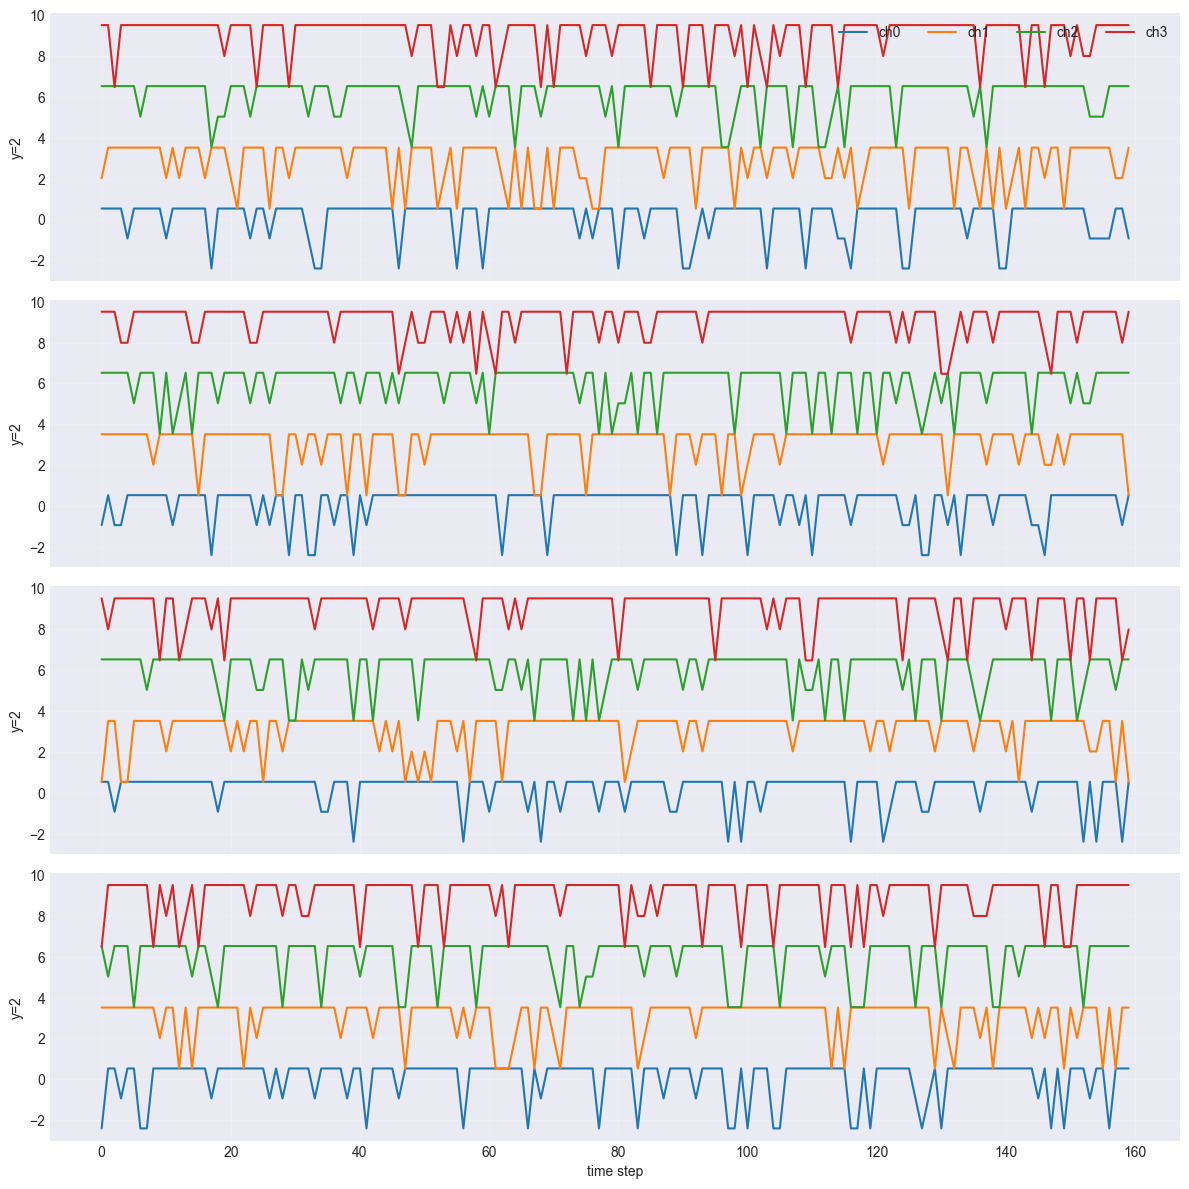

Validation batch shapes: x=torch.Size([32, 160, 37]), y=torch.Size([32]), mask=torch.Size([32, 160])


In [118]:
## 13. DataLoader e analisi rapida dei batch
from collections import Counter
from torch.utils.data import DataLoader, WeightedRandomSampler

if 'hp_state' not in globals():
    raise RuntimeError("Esegui prima le celle degli iperparametri per costruire hp_state.")

class_counts = np.bincount(y_train_enc)
augmentor = TimeSeriesAugmentor(class_counts=class_counts)

train_dataset = TimeSeriesDataset(
    X_train_std,
    y_train_enc,
    mask=train_mask,
    train=True,
    augment=augmentor
)

val_dataset = TimeSeriesDataset(
    X_val_std,
    y_val_enc,
    mask=val_mask,
    train=False,
    augment=None
)

class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = torch.tensor(class_weights[y_train_enc], dtype=torch.double)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = int(hp_state['batch_size'])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    drop_last=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)

def visualize_batch(batch, n=4, chans=4):
    x = batch["x"].detach().cpu().numpy()
    y = batch["y"].detach().cpu().numpy()
    mask = batch["mask"].detach().cpu().numpy() > 0.5
    n = min(n, x.shape[0])
    chans = min(chans, x.shape[2])
    fig, axes = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=True)
    if n == 1:
        axes = [axes]
    time = np.arange(x.shape[1])
    color_cycle = plt.cm.tab10(np.arange(chans))
    offset = 3.0
    for idx in range(n):
        ax = axes[idx]
        valid_mask = mask[idx]
        series = x[idx, :, :chans]
        for ch in range(chans):
            ax.plot(time, series[:, ch] + ch * offset, color=color_cycle[ch % len(color_cycle)], label=f"ch{ch}")
        pad = ~valid_mask
        if pad.any():
            pad_edges = np.diff(np.concatenate(([0], pad.astype(int), [0])))
            starts = np.where(pad_edges == 1)[0]
            ends = np.where(pad_edges == -1)[0]
            for start, end in zip(starts, ends):
                ax.axvspan(start, end - 1, color="lightgray", alpha=0.3)
        ax.set_ylabel(f"y={int(y[idx])}")
        ax.grid(alpha=0.2)
    axes[-1].set_xlabel("time step")
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(loc="upper right", ncol=min(chans, 4))
    plt.tight_layout()
    plt.show()

train_dataset.reset_epoch()
num_batches_check = 5
class_counter = Counter()
checked_batches = []
train_iter = iter(train_loader)
for _ in range(num_batches_check):
    try:
        batch = next(train_iter)
    except StopIteration:
        break
    checked_batches.append(batch)
    class_counter.update(batch["y"].cpu().numpy().tolist())

if checked_batches:
    sample_batch = checked_batches[0]
    print(f"Train batch shapes: x={sample_batch['x'].shape}, y={sample_batch['y'].shape}, mask={sample_batch['mask'].shape}")
    total_samples = sum(class_counter.values())
    if total_samples:
        dist_est = {cls: f"{count / total_samples:.2%}" for cls, count in sorted(class_counter.items())}
        print(f"Approx. class distribution over first {len(checked_batches)} train batches: {dist_est}")
    visualize_batch(sample_batch)
else:
    print("Sampler produced no batches; adjust batch_size or dataset.")

train_dataset.reset_epoch()
val_batch = next(iter(val_loader))
print(f"Validation batch shapes: x={val_batch['x'].shape}, y={val_batch['y'].shape}, mask={val_batch['mask'].shape}")

#### Funzione `visualize_batch`
Disegna i primi canali di alcune sequenze di un batch evidenziando i frame di padding, utile per verificare augmentation e maschere.

### 8.3 Analisi dell'addestramento
Visualizziamo andamento di loss e F1 per individuare eventuale overfitting e scegliere il modello migliore.

## CNN Hyperparameters
Seleziona i parametri principali dei blocchi convoluzionali che estraggono pattern locali dalle sequenze.

In [ ]:
## 13bis-a. CNN Hyperparameters
cnn_params = {
    'conv_channels': 32,
    'conv_kernel_1': 3,
    'conv_kernel_2': 3,
    'pool_kernel': 2,
}
print('CNN hyperparameters:', cnn_params)

CNN hyperparameters: {'conv_channels': 64, 'conv_kernel_1': 5, 'conv_kernel_2': 3, 'pool_kernel': 2}


## LSTM Hyperparameters
Imposta le dimensioni dei layer ricorrenti e dell'attenzione per modellare le dinamiche temporali.

In [120]:
## 13bis-b. LSTM Hyperparameters
lstm_params = {
    'lstm_hidden': 128,
    'second_lstm_hidden': 64,
    'attention_dim': 128,
}
print('LSTM hyperparameters:', lstm_params)

LSTM hyperparameters: {'lstm_hidden': 128, 'second_lstm_hidden': 64, 'attention_dim': 128}


## Loss & Regularization Hyperparameters
Configura gli iperparametri di training legati a ottimizzazione, pesi di classe e regolarizzazione.

In [121]:
## 13bis-c. Loss & Regularization Hyperparameters
training_params = {
    'learning_rate': 5e-4,
    'weight_decay': 3e-4,
    'dropout': 0.5,
    'focal_gamma': 1.5,
    'batch_size': 32,
    'patience': 5,
    'max_epochs': 50,
}
print('Training hyperparameters:', training_params)

Training hyperparameters: {'learning_rate': 0.0005, 'weight_decay': 0.0003, 'dropout': 0.5, 'focal_gamma': 1.5, 'batch_size': 32, 'patience': 5, 'max_epochs': 50}


## Hyperparameter Summary
Combiniamo i parametri scelti nei tre blocchi in un unico dizionario `hp_state` utilizzato nei loader e nel training.

In [122]:
## 13bis-d. Assemble Hyperparameters
hp_state = {}
hp_state.update(cnn_params if 'cnn_params' in globals() else {})
hp_state.update(lstm_params if 'lstm_params' in globals() else {})
hp_state.update(training_params if 'training_params' in globals() else {})

required_keys = [
    'conv_channels',
    'conv_kernel_1',
    'conv_kernel_2',
    'pool_kernel',
    'lstm_hidden',
    'second_lstm_hidden',
    'attention_dim',
    'learning_rate',
    'weight_decay',
    'dropout',
    'focal_gamma',
    'batch_size',
    'patience',
    'max_epochs',
]

missing_keys = [k for k in required_keys if k not in hp_state]
if missing_keys:
    raise KeyError(f"Parametri mancanti in hp_state: {missing_keys}")
else:
    print('Hyperparameters ready:', hp_state)

Hyperparameters ready: {'conv_channels': 64, 'conv_kernel_1': 5, 'conv_kernel_2': 3, 'pool_kernel': 2, 'lstm_hidden': 128, 'second_lstm_hidden': 64, 'attention_dim': 128, 'learning_rate': 0.0005, 'weight_decay': 0.0003, 'dropout': 0.5, 'focal_gamma': 1.5, 'batch_size': 32, 'patience': 5, 'max_epochs': 50}


In [123]:
## 14. Modello PyTorch e training
import copy
from datetime import datetime
from pathlib import Path
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = device.type == "cuda"
print(f"Using device: {device} | Mixed precision: {use_amp}")

num_classes = len(class_counts)
input_dim = X_train_std.shape[-1]

hyperparams = {
    'learning_rate': float(hp_state['learning_rate']),
    'weight_decay': float(hp_state['weight_decay']),
    'dropout': float(hp_state['dropout']),
    'focal_gamma': float(hp_state['focal_gamma']),
    'patience': int(hp_state['patience']),
    'max_epochs': int(hp_state['max_epochs']),
    'conv_channels': int(hp_state['conv_channels']),
    'conv_kernel_1': int(hp_state['conv_kernel_1']),
    'conv_kernel_2': int(hp_state['conv_kernel_2']),
    'pool_kernel': int(hp_state['pool_kernel']),
    'lstm_hidden': int(hp_state['lstm_hidden']),
    'second_lstm_hidden': int(hp_state['second_lstm_hidden']),
    'attention_dim': int(hp_state['attention_dim']),
}

class_counts_safe = np.maximum(class_counts, 1)
class_weights_np = 1.0 / class_counts_safe
class_weights_np = class_weights_np * (num_classes / class_weights_np.sum())
alpha_np = class_weights_np / class_weights_np.sum()
class_weight_tensor = torch.tensor(class_weights_np, dtype=torch.float32, device=device)
alpha_tensor = torch.tensor(alpha_np, dtype=torch.float32, device=device)

Using device: cpu | Mixed precision: False


#### Classe `FocalLoss`
Implementa la loss focal con pesi per classe, attenuando l'impatto delle classi maggioritarie durante l'addestramento.

In [124]:
class FocalLoss(nn.Module):
    """Implementazione della focal loss con pesi per classe."""
    def __init__(self, alpha, gamma=1.5, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.register_buffer('alpha', alpha.float())

    def forward(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)
        probs = log_probs.exp()
        targets_one_hot = F.one_hot(targets, num_classes=logits.size(-1)).type_as(log_probs)
        pt = torch.sum(targets_one_hot * probs, dim=-1)
        focal_factor = (1.0 - pt).clamp(min=0).pow(self.gamma)
        ce_loss = -torch.sum(targets_one_hot * log_probs, dim=-1)
        alpha_t = self.alpha[targets]
        loss = alpha_t * focal_factor * ce_loss
        if self.reduction == 'mean':
            return loss.mean()
        if self.reduction == 'sum':
            return loss.sum()
        return loss

#### Classe `TimeSeriesNet`
Rete ibrida conv-BiLSTM con attenzione additiva: comprime localmente, cattura dinamiche temporali bidirezionali e sintetizza un contesto pesato per classificare il livello di dolore.

In [125]:
class TimeSeriesNet(nn.Module):
    """Rete ibrida conv + BiLSTM con blocco di attenzione configurabile."""
    def __init__(self, input_dim, num_classes, *, conv_channels, conv_kernel_1, conv_kernel_2, pool_kernel,
                 lstm_hidden, second_lstm_hidden, attention_dim, dropout):
        super().__init__()
        attn_input_dim = second_lstm_hidden * 2
        self.conv1 = nn.Conv1d(input_dim, conv_channels, kernel_size=conv_kernel_1, padding=conv_kernel_1 // 2)
        self.bn1 = nn.BatchNorm1d(conv_channels)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels * 2, kernel_size=conv_kernel_2, padding=conv_kernel_2 // 2)
        self.bn2 = nn.BatchNorm1d(conv_channels * 2)
        self.pool1 = nn.MaxPool1d(kernel_size=pool_kernel, stride=pool_kernel, ceil_mode=True)
        self.pool2 = nn.MaxPool1d(kernel_size=pool_kernel, stride=pool_kernel, ceil_mode=True)
        self.lstm1 = nn.LSTM(input_size=conv_channels * 2, hidden_size=lstm_hidden, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=lstm_hidden * 2, hidden_size=second_lstm_hidden, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=dropout)
        self.attn_proj = nn.Linear(attn_input_dim, attention_dim)
        self.attn_score = nn.Linear(attention_dim, 1)
        self.fc = nn.Linear(attention_dim, attention_dim)
        self.out = nn.Linear(attention_dim, num_classes)

    def forward(self, x, mask=None):
        if mask is None:
            mask = torch.ones(x.size(0), x.size(1), device=x.device, dtype=torch.float32)
        mask = mask.float()

        out = x.transpose(1, 2)
        out = F.relu(self.bn1(self.conv1(out)))
        out = self.pool1(out)
        mask = F.max_pool1d(mask.unsqueeze(1), kernel_size=self.pool1.kernel_size, stride=self.pool1.stride, ceil_mode=True).squeeze(1)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.pool2(out)
        mask = F.max_pool1d(mask.unsqueeze(1), kernel_size=self.pool2.kernel_size, stride=self.pool2.stride, ceil_mode=True).squeeze(1)
        out = out.transpose(1, 2)
        mask_bool = mask > 0.5

        out, _ = self.lstm1(out)
        out = self.dropout(out)
        out, _ = self.lstm2(out)
        out = self.dropout(out)

        attn_hidden = torch.tanh(self.attn_proj(out))
        attn_scores = self.attn_score(attn_hidden).squeeze(-1)
        attn_scores = attn_scores.masked_fill(~mask_bool, -1e9)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = attn_weights * mask_bool.float()
        attn_weights = attn_weights / (attn_weights.sum(dim=-1, keepdim=True) + 1e-8)

        context = torch.sum(out * attn_weights.unsqueeze(-1), dim=1)
        context = self.dropout(F.relu(self.fc(context)))
        context = self.dropout(context)
        return self.out(context)

#### Funzione `compute_f1_macro`
Calcola la macro F1 su vettori numpy; usata per monitorare il bilanciamento delle prestazioni tra classi.

In [126]:
def compute_f1_macro(y_true, y_pred):
    """Restituisce la macro F1, robusta all'imbalanciamento."""
    if len(y_true) == 0:
        return 0.0
    return f1_score(y_true, y_pred, average='macro', zero_division=0)

#### Funzione `train_one_epoch`
Esegue un'epoca di training con mixed precision opzionale, gradient clipping e aggiornamento dei contatori d'uso nel dataset.

In [127]:
def train_one_epoch(model, loader, dataset, criterion, optimizer, scaler, device, use_amp):
    """Esegue un'epoca di training con supporto AMP, gradient clipping e ritorna loss e F1."""
    model.train()
    dataset.reset_epoch()
    running_loss = 0.0
    total = 0
    all_preds = []
    all_targets = []
    for batch in loader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        mask = batch['mask'].to(device)
        optimizer.zero_grad(set_to_none=True)
        if use_amp:
            with torch.cuda.amp.autocast(enabled=True):
                logits = model(x, mask)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x, mask)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        running_loss += loss.item() * x.size(0)
        total += x.size(0)
        preds = torch.argmax(logits.detach(), dim=-1)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())
    if total == 0:
        return 0.0, 0.0
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()
    f1_macro = compute_f1_macro(y_true, y_pred)
    return running_loss / total, f1_macro

#### Funzione `evaluate`
Valuta il modello sul validation loader restituendo loss, macro F1, recall per classe e le predizioni per successive analisi.

In [128]:
def evaluate(model, loader, criterion, device):
    """Valuta il modello restituendo loss, macro F1 e recall per classe."""
    model.eval()
    running_loss = 0.0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            mask = batch['mask'].to(device)
            logits = model(x, mask)
            loss = criterion(logits, y)
            running_loss += loss.item() * x.size(0)
            total += x.size(0)
            preds = torch.argmax(logits, dim=-1)
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())
    if total == 0:
        return 0.0, 0.0, np.zeros(num_classes), np.array([]), np.array([])
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()
    avg_loss = running_loss / total
    f1_macro = compute_f1_macro(y_true, y_pred)
    recalls = recall_score(y_true, y_pred, average=None, labels=np.arange(num_classes), zero_division=0)
    return avg_loss, f1_macro, recalls, y_pred, y_true

#### Esecuzione del training
Impostiamo loss/ottimizzatore e avviamo il loop con early stopping e scheduler.

In [129]:
use_focal_loss = True
criterion = FocalLoss(alpha_tensor, gamma=hyperparams['focal_gamma']) if use_focal_loss else nn.CrossEntropyLoss(weight=class_weight_tensor)
criterion = criterion.to(device)

model = TimeSeriesNet(
    input_dim=input_dim,
    num_classes=num_classes,
    conv_channels=hyperparams['conv_channels'],
    conv_kernel_1=hyperparams['conv_kernel_1'],
    conv_kernel_2=hyperparams['conv_kernel_2'],
    pool_kernel=hyperparams['pool_kernel'],
    lstm_hidden=hyperparams['lstm_hidden'],
    second_lstm_hidden=hyperparams['second_lstm_hidden'],
    attention_dim=hyperparams['attention_dim'],
    dropout=hyperparams['dropout']
 ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, min_lr=1e-5)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

log_root = Path('runs')
log_root.mkdir(parents=True, exist_ok=True)
tb_log_dir = log_root / f"pain_logs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir=str(tb_log_dir))

best_state = None
best_f1 = -np.inf
best_preds = None
best_targets = None
patience = hyperparams['patience']
wait = 0
max_epochs = hyperparams['max_epochs']

for epoch in range(1, max_epochs + 1):
    train_loss, train_f1 = train_one_epoch(model, train_loader, train_dataset, criterion, optimizer, scaler, device, use_amp)
    val_loss, val_f1, val_recalls, val_preds, val_targets = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_f1)
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('F1/train', train_f1, epoch)
    writer.add_scalar('F1/val', val_f1, epoch)
    writer.add_scalar('LR', optimizer.param_groups[0]['lr'], epoch)
    recalls_str = ', '.join([f"class {i}: {rec:.3f}" for i, rec in enumerate(val_recalls)])
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train F1-macro: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1-macro: {val_f1:.4f}")
    print(f"             Val recall -> {recalls_str}")
    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1
        best_state = copy.deepcopy(model.state_dict())
        best_preds = val_preds
        best_targets = val_targets
        wait = 0
        print("             New best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

writer.flush()
writer.close()
print(f"TensorBoard log directory: {tb_log_dir}")

print("Training complete.")
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Best validation F1-macro: {best_f1:.4f}")
else:
    print("Warning: no best state captured; using final model.")

final_loss, final_f1, final_recalls, final_preds, final_targets = evaluate(model, val_loader, criterion, device)
if final_preds.size == 0:
    print("Validation set is empty.")
else:
    target_names = list(label_encoder.classes_) if 'label_encoder' in globals() else [str(i) for i in range(num_classes)]
    report = classification_report(final_targets, final_preds, labels=np.arange(num_classes), target_names=target_names, digits=4, zero_division=0)
    cm = confusion_matrix(final_targets, final_preds, labels=np.arange(num_classes))
    print(report)
    print("Confusion matrix:\n", cm)

Epoch 01 | Train Loss: 0.1583 | Train F1-macro: 0.2490 | Val Loss: 0.0945 | Val F1-macro: 0.0509
             Val recall -> class 0: 1.000, class 1: 0.000, class 2: 0.000
             New best model saved.
Epoch 02 | Train Loss: 0.1321 | Train F1-macro: 0.2914 | Val Loss: 0.0979 | Val F1-macro: 0.1964
             Val recall -> class 0: 1.000, class 1: 0.632, class 2: 0.000
             New best model saved.
Epoch 02 | Train Loss: 0.1321 | Train F1-macro: 0.2914 | Val Loss: 0.0979 | Val F1-macro: 0.1964
             Val recall -> class 0: 1.000, class 1: 0.632, class 2: 0.000
             New best model saved.
Epoch 03 | Train Loss: 0.1108 | Train F1-macro: 0.4289 | Val Loss: 0.1051 | Val F1-macro: 0.1689
             Val recall -> class 0: 0.909, class 1: 0.526, class 2: 0.000
Epoch 03 | Train Loss: 0.1108 | Train F1-macro: 0.4289 | Val Loss: 0.1051 | Val F1-macro: 0.1689
             Val recall -> class 0: 0.909, class 1: 0.526, class 2: 0.000
Epoch 04 | Train Loss: 0.0867 | Train F1

## Sezione 9 · Inference e submission
Una volta selezionato il checkpoint con la migliore macro F1, generiamo le predizioni sul test set e creiamo il file di submission per Kaggle.

### 9.1 Generazione delle predizioni
Ricarichiamo i pesi migliori, eseguiamo il modello sul test set con `torch.no_grad()` e recuperiamo le probabilità mediate sui frame disponibili.

In [130]:
## 15. Riepilogo metriche
print(f"Best validation F1-macro: {best_f1:.4f}")
print(f"Final validation F1-macro (re-evaluated): {final_f1:.4f}")
print("Per-class recall:", final_recalls)
print("Confusion matrix:\n", cm)

Best validation F1-macro: 0.8129
Final validation F1-macro (re-evaluated): 0.8129
Per-class recall: [0.81818182 0.94736842 0.89320388]
Confusion matrix:
 [[ 9  1  1]
 [ 1 18  0]
 [ 9  2 92]]


### 9.1bis Visualizzazione TensorBoard
Mostriamo l'andamento della macro F1 su training e validation direttamente dai log salvati in `runs/`.

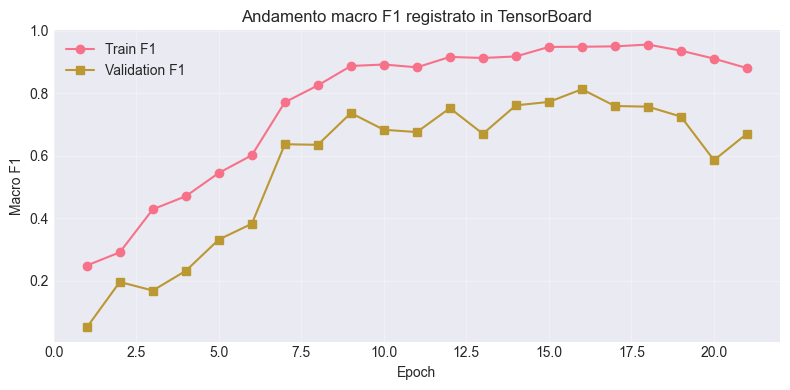

Log TensorBoard utilizzato: runs\pain_logs_20251111_155457


In [131]:
## 15bis. Plot F1 from TensorBoard logs
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

if 'tb_log_dir' not in globals():
    raise RuntimeError("Nessun log TensorBoard disponibile: esegui il training prima di questa cella.")

log_path = Path(tb_log_dir)
if not log_path.exists():
    raise FileNotFoundError(f"Directory TensorBoard non trovata: {log_path}")

ea = event_accumulator.EventAccumulator(str(log_path))
ea.Reload()
train_f1 = ea.Scalars('F1/train')
val_f1 = ea.Scalars('F1/val')

if not train_f1 or not val_f1:
    raise ValueError("Non sono presenti curve F1 nei log: controlla che il training sia stato eseguito completamente.")

train_steps = [item.step for item in train_f1]
train_values = [item.value for item in train_f1]
val_steps = [item.step for item in val_f1]
val_values = [item.value for item in val_f1]

plt.figure(figsize=(8, 4))
plt.plot(train_steps, train_values, marker='o', label='Train F1')
plt.plot(val_steps, val_values, marker='s', label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.title('Andamento macro F1 registrato in TensorBoard')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f'Log TensorBoard utilizzato: {log_path}')

## Sezione 8 · Ricerca automatica degli iperparametri
Eseguiamo una piccola grid search utilizzando i loader già preparati per confrontare varianti del modello CNN/BiLSTM con pooling mask-aware.

In [133]:
## 17. Funzioni di supporto per la grid search
import copy
import itertools
import random
from typing import Dict, Any, Tuple

def set_global_seed(seed: int = 42) -> None:
    """Imposta il seed per NumPy, random e PyTorch per run riproducibili."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def build_model(params: Dict[str, Any]) -> nn.Module:
    """Costruisce un modello CNN con opzionale BiLSTM e pooling mask-aware."""
    conv_channels = int(params['conv_channels'])
    kernel1 = int(params['conv_kernel_1'])
    kernel2 = int(params.get('conv_kernel_2', 3))
    dropout = float(params.get('dropout', 0.3))
    use_bilstm = bool(params.get('use_bilstm', True))
    lstm_hidden = int(params.get('lstm_hidden', 64))
    lstm_layers = int(params.get('lstm_layers', 1))
    pooling = params.get('pooling', 'attention')

    class SearchNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.use_bilstm = use_bilstm
            self.pooling = pooling
            self.conv1 = nn.Conv1d(input_dim, conv_channels, kernel_size=kernel1, padding=kernel1 // 2)
            self.bn1 = nn.BatchNorm1d(conv_channels)
            self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=kernel2, padding=kernel2 // 2)
            self.bn2 = nn.BatchNorm1d(conv_channels)
            feature_dim = conv_channels
            if self.use_bilstm:
                self.lstm = nn.LSTM(
                    input_size=conv_channels,
                    hidden_size=lstm_hidden,
                    num_layers=lstm_layers,
                    batch_first=True,
                    bidirectional=True,
                    dropout=0.1 if lstm_layers > 1 else 0.0
                )
                feature_dim = lstm_hidden * 2
            if self.pooling == 'attention':
                self.attn_proj = nn.Linear(feature_dim, feature_dim)
                self.attn_score = nn.Linear(feature_dim, 1)
            self.dropout = nn.Dropout(dropout)
            self.head = nn.Linear(feature_dim, num_classes)

        def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
            mask = mask.float()
            feats = x.transpose(1, 2)
            feats = torch.relu(self.bn1(self.conv1(feats)))
            feats = torch.relu(self.bn2(self.conv2(feats)))
            feats = feats.transpose(1, 2)
            mask_cut = mask[:, :feats.size(1)]
            if self.use_bilstm:
                lengths = mask_cut.sum(dim=1).to(torch.int64)
                packed = nn.utils.rnn.pack_padded_sequence(
                    feats, lengths.cpu(), batch_first=True, enforce_sorted=False
                )
                packed_out, _ = self.lstm(packed)
                feats, _ = nn.utils.rnn.pad_packed_sequence(
                    packed_out, batch_first=True, total_length=feats.size(1)
                )
                mask_cut = mask_cut[:, :feats.size(1)]
            if self.pooling == 'attention':
                scores = self.attn_score(torch.tanh(self.attn_proj(feats))).squeeze(-1)
                scores = scores.masked_fill(mask_cut == 0, -1e9)
                weights = torch.softmax(scores, dim=1)
                context = torch.sum(feats * weights.unsqueeze(-1), dim=1)
            else:
                mask_exp = mask_cut.unsqueeze(-1)
                context = (feats * mask_exp).sum(dim=1) / mask_exp.sum(dim=1).clamp(min=1e-6)
            context = self.dropout(context)
            return self.head(context)

    return SearchNet()

def train_eval(params: Dict[str, Any], *, max_epochs: int = 18, seed: int = 42) -> Dict[str, Any]:
    """Allena il modello con AdamW, early stopping su F1 macro e restituisce le metriche."""
    set_global_seed(seed)
    model = build_model(params).to(device)

    loss_type = params.get('loss_type', 'focal')
    if loss_type == 'focal':
        gamma = float(params.get('focal_gamma', 1.5))
        criterion_local = FocalLoss(alpha_tensor, gamma=gamma).to(device)
    else:
        criterion_local = nn.CrossEntropyLoss(weight=class_weight_tensor).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=float(params['lr']), weight_decay=float(params['weight_decay'])
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-5
    )

    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
    best_state = None
    best_f1 = -np.inf
    wait = 0
    patience = int(params.get('patience', 8))

    def _forward_epoch(train: bool) -> Tuple[float, float]:
        running_loss = 0.0
        total = 0
        preds_list = []
        targets_list = []
        if train:
            model.train()
            if 'train_dataset' in globals() and hasattr(train_dataset, 'reset_epoch'):
                train_dataset.reset_epoch()
        else:
            model.eval()
        data_iter = train_loader if train else val_loader
        for batch in data_iter:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            mask = batch['mask'].to(device)
            if train:
                optimizer.zero_grad(set_to_none=True)
                logits = model(x, mask)
                loss = criterion_local(logits, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            else:
                with torch.no_grad():
                    logits = model(x, mask)
                    loss = criterion_local(logits, y)
            running_loss += loss.item() * x.size(0)
            total += x.size(0)
            preds_list.append(torch.argmax(logits.detach(), dim=-1).cpu())
            targets_list.append(y.cpu())
        if total == 0:
            return 0.0, 0.0
        preds_np = torch.cat(preds_list).numpy()
        targets_np = torch.cat(targets_list).numpy()
        avg_loss = running_loss / total
        f1_macro = compute_f1_macro(targets_np, preds_np)
        return avg_loss, f1_macro

    for epoch in range(1, max_epochs + 1):
        train_loss, train_f1 = _forward_epoch(train=True)
        val_loss, val_f1 = _forward_epoch(train=False)
        scheduler.step(val_f1)
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        if val_f1 > best_f1 + 1e-4:
            best_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return {
        'model': model,
        'model_state': best_state,
        'best_f1': best_f1,
        'history': history
    }

In [134]:
## 18. Grid search compatta
search_space = {
    'conv_channels': [32, 64],
    'conv_kernel_1': [3, 5],
    'use_bilstm': [True, False],
    'lstm_hidden': [32, 64],
    'lstm_layers': [1, 2],
    'pooling': ['attention', 'mean'],
    'dropout': [0.3, 0.5],
    'weight_decay': [1e-4, 3e-4, 5e-4],
    'lr': [1e-3, 5e-4],
    'loss_type': ['focal', 'ce'],
    'focal_gamma': [1.0, 1.5],
}

keys = list(search_space.keys())
all_combinations = []
for values in itertools.product(*search_space.values()):
    combo = dict(zip(keys, values))
    if not combo['use_bilstm'] and combo['lstm_layers'] > 1:
        continue
    if combo['loss_type'] == 'ce':
        combo['focal_gamma'] = None
    all_combinations.append(combo)

random.Random(SEED).shuffle(all_combinations)
max_runs = 12  # limitiamo la ricerca per mantenere i tempi gestibili
candidate_combinations = all_combinations[:max_runs]

grid_results = []
detailed_results = []

for run_id, combo in enumerate(candidate_combinations, start=1):
    params = dict(combo)
    params['patience'] = 8
    params['conv_kernel_2'] = 3
    run_seed = SEED + run_id
    params['seed'] = run_seed
    result = train_eval(params, max_epochs=18, seed=run_seed)
    row = {k: params.get(k) for k in combo.keys()}
    row['run_id'] = run_id
    row['best_f1'] = result['best_f1']
    grid_results.append(row)
    detailed_results.append({'run_id': run_id, 'params': params, 'result': result})
    print(f"Run {run_id:02d}/{len(candidate_combinations)} | best F1: {result['best_f1']:.4f}")

grid_df = pd.DataFrame(grid_results)
summary_df = grid_df.sort_values('best_f1', ascending=False).reset_index(drop=True)
summary_df

Run 01/12 | best F1: 0.7796
Run 02/12 | best F1: 0.5611
Run 03/12 | best F1: 0.7923
Run 04/12 | best F1: 0.7213
Run 05/12 | best F1: 0.7073
Run 06/12 | best F1: 0.7316
Run 07/12 | best F1: 0.7574
Run 08/12 | best F1: 0.5205
Run 09/12 | best F1: 0.3577
Run 10/12 | best F1: 0.5481
Run 11/12 | best F1: 0.7702
Run 12/12 | best F1: 0.5709


,conv_channels,conv_kernel_1,use_bilstm,lstm_hidden,lstm_layers,pooling,dropout,weight_decay,lr,loss_type,focal_gamma,run_id,best_f1
0,64,3,True,64,2,attention,0.3,0.0005,0.0010,focal,1.5,3,0.792322
1,64,5,True,32,1,mean,0.5,0.0001,0.0010,focal,1.5,1,0.779592
2,64,5,True,32,1,attention,0.5,0.0001,0.0010,ce,NaN,11,0.770212
3,64,3,True,32,2,mean,0.5,0.0003,0.0005,focal,1.5,7,0.757402
4,64,5,False,32,1,attention,0.5,0.0005,0.0010,focal,1.0,6,0.731632
5,32,3,True,32,1,mean,0.3,0.0003,0.0010,focal,1.0,4,0.721339
6,32,3,True,64,1,mean,0.3,0.0003,0.0010,ce,NaN,5,0.707317
7,64,3,False,32,1,mean,0.3,0.0003,0.0005,focal,1.5,12,0.570862
8,64,3,False,64,1,attention,0.3,0.0005,0.0005,ce,NaN,2,0.561085
9,64,5,False,32,1,mean,0.5,0.0005,0.0005,focal,1.0,10,0.548063


Migliore configurazione trovata:
  conv_channels: 64
  conv_kernel_1: 3
  use_bilstm: True
  lstm_hidden: 64
  lstm_layers: 2
  pooling: attention
  dropout: 0.3
  weight_decay: 0.0005
  lr: 0.001
  loss_type: focal
  focal_gamma: 1.5
  patience: 8
  conv_kernel_2: 3
  seed: 10


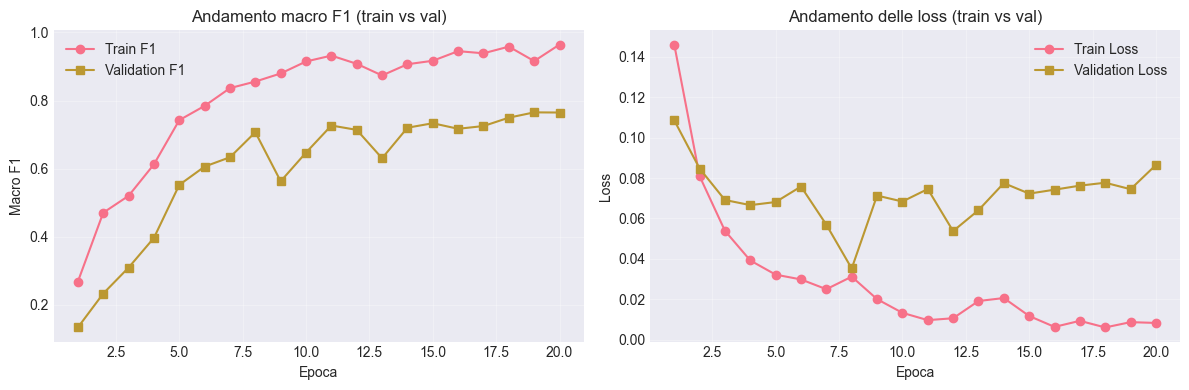

Le curve mostrano la macro F1 e la loss su training/validation per l'assetto migliore:
osservare la stabilizzazione della F1 e l'assenza di overfitting marcato aiuta a giudicare la bontà dell'iperparametrizzazione.


In [135]:
## 19. Retrain e visualizzazione della combinazione migliore
if summary_df.empty:
    raise RuntimeError("La grid search non ha prodotto risultati: verifica gli iperparametri.")

best_run_id = int(summary_df.loc[0, 'run_id'])
best_entry = next(item for item in detailed_results if item['run_id'] == best_run_id)
best_params = dict(best_entry['params'])
best_seed = best_params.get('seed', SEED)

print("Migliore configurazione trovata:")
for key, value in best_params.items():
    if key in {'model_state'}:
        continue
    print(f"  {key}: {value}")

retrain_params = dict(best_params)
retrain_result = train_eval(retrain_params, max_epochs=20, seed=best_seed)
history = retrain_result['history']
epochs = np.arange(1, len(history['val_f1']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(epochs, history['train_f1'], marker='o', label='Train F1')
axes[0].plot(epochs, history['val_f1'], marker='s', label='Validation F1')
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Macro F1')
axes[0].set_title('Andamento macro F1 (train vs val)')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(epochs, history['train_loss'], marker='o', label='Train Loss')
axes[1].plot(epochs, history['val_loss'], marker='s', label='Validation Loss')
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Loss')
axes[1].set_title('Andamento delle loss (train vs val)')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(
    "Le curve mostrano la macro F1 e la loss su training/validation per l'assetto migliore:",
    "osservare la stabilizzazione della F1 e l'assenza di overfitting marcato aiuta a giudicare la bontà dell'iperparametrizzazione.",
    sep='\n'
 )

### 9.2 Esportazione CSV
Convertiamo le predizioni in label discrete, le abbiniamo agli `series_id` e salviamo un CSV pronto per la submission.

In [136]:
## 16. Submission: generazione file finale
import os
import torch.nn.functional as F

if best_state is not None:
    model.load_state_dict(best_state)

model.eval()

test_df = pd.read_csv('pirate_pain_test.csv')

id_columns = ['sample_index', 'time']
if 'remaining_features' in globals():
    feature_order = list(remaining_features)
else:
    feature_order = [col for col in X_train.columns if col not in id_columns]

for col in feature_order:
    if col not in test_df.columns:
        test_df[col] = 0

ordered_columns = id_columns + feature_order
test_df = test_df[ordered_columns]

sample_indices_test = np.sort(test_df['sample_index'].unique())
num_samples_test = sample_indices_test.size
T = max_len
feature_dim = input_dim

X_test_padded = np.zeros((num_samples_test, T, feature_dim), dtype=np.float32)
mask_test = np.zeros((num_samples_test, T), dtype=bool)

for i, sample_idx in enumerate(sample_indices_test):
    sample_data = test_df[test_df['sample_index'] == sample_idx].sort_values('time')
    features = preprocess_features(sample_data)
    if features.shape[1] != feature_dim:
        raise ValueError(f"Unexpected feature dimension {features.shape[1]} for sample {sample_idx}; expected {feature_dim}")
    seq_len = min(features.shape[0], T)
    X_test_padded[i, :seq_len] = features[:seq_len]
    mask_test[i, :seq_len] = True

X_test_std = standardize(X_test_padded, mu, sigma, mask=mask_test)

dummy_labels = np.zeros(num_samples_test, dtype=np.int64)
test_dataset = TimeSeriesDataset(
    X_test_std,
    dummy_labels,
    mask=mask_test,
    train=False,
    augment=None
)
test_dataset.reset_epoch()

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)

pred_classes = []
softmax = nn.Softmax(dim=-1)

with torch.no_grad():
    for batch in test_loader:
        x = batch['x'].to(device)
        mask_batch = batch['mask'].to(device)
        logits = model(x, mask_batch)
        probs = softmax(logits)
        preds = torch.argmax(probs, dim=-1)
        pred_classes.extend(preds.cpu().numpy().tolist())

pred_classes = np.array(pred_classes, dtype=np.int64)

if 'label_encoder' in globals():
    pred_labels = label_encoder.inverse_transform(pred_classes)
else:
    default_id2label = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
    pred_labels = np.vectorize(default_id2label.get)(pred_classes)

submission_df = pd.DataFrame({
    'sample_index': sample_indices_test,
    'label': pred_labels
}).sort_values('sample_index').reset_index(drop=True)

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to: {os.path.abspath(submission_path)}")
print(submission_df.head())

Submission saved to: c:\Users\filip\Documents\GitHub\challenge_an2dl\submission.csv
   sample_index      label
0             0    no_pain
1             1    no_pain
2             2    no_pain
3             3  high_pain
4             4    no_pain
